In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import SparseCoder
import scipy
from scipy import sparse
from scipy import linalg
from scipy import special, pi
from scipy import integrate
from scipy.fft import fft, fftshift, fftfreq, ifft, ifft2, fft2, ifftshift
from scipy import signal


# Sparse coding with a precomputed dictionary

Transform a signal as a sparse combination of Ricker wavelets. This example
visually compares different sparse coding methods using the
:class:`~sklearn.decomposition.SparseCoder` estimator. The Ricker (also known
as Mexican hat or the second derivative of a Gaussian) is not a particularly
good kernel to represent piecewise constant signals like this one. It can
therefore be seen how much adding different widths of atoms matters and it
therefore motivates learning the dictionary to best fit your type of signals.

The richer dictionary on the right is not larger in size, heavier subsampling
is performed in order to stay on the same order of magnitude.


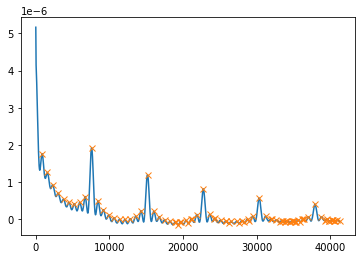

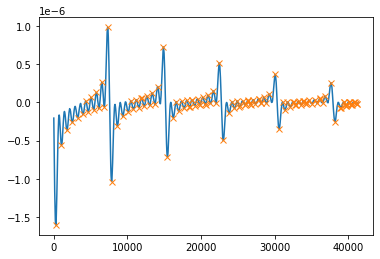

(1000,)


In [10]:
au2cm = 219474.6305
auScale= 0.0000046
au2fs = 0.02418884254
scaling = 1.0 #/ (1000 / au2cm) #1.0 / __(1000, energy_unit).au


n_pts = 1000
n_ltc = 10

t_learn = (1.0e3 / au2fs) / scaling
t_test = (1.0e3 / au2fs) / scaling
t_min = (1.0e-3 / au2fs) / scaling

#learn_domain = np.logspace(np.log2(t_min), np.log2(t_learn), num=n_pts, base=2)
#test_domain = np.logspace(np.log2(t_min), np.log2(t_test), num=n_pts, base=2)
learn_domain = np.linspace(0, t_learn, num=n_pts)
test_domain = np.linspace(0, t_test, num=n_pts)

file_learn = open('learn_db_10_lin.csv', 'r')#for lin space x distribution
#file_learn = open('learn_db_10_lin_scale.csv', 'r')
learn_s, test_s,learn_a, test_a = np.loadtxt(file_learn ,delimiter = ",")

peak_s, a = signal.find_peaks(learn_s)
peak_a, a = signal.find_peaks(abs(learn_a))
plt.plot(learn_domain, learn_s)
plt.plot(learn_domain[peak_s], learn_s[peak_s], "x")
#plt.xscale('log')
plt.show()
plt.plot(learn_domain, learn_a)
plt.plot(learn_domain[peak_a], learn_a[peak_a], "x")
#plt.xscale('log')
plt.show()

print(learn_s.shape)

C:\Users\Alienware\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  return f(*args, **kwargs)


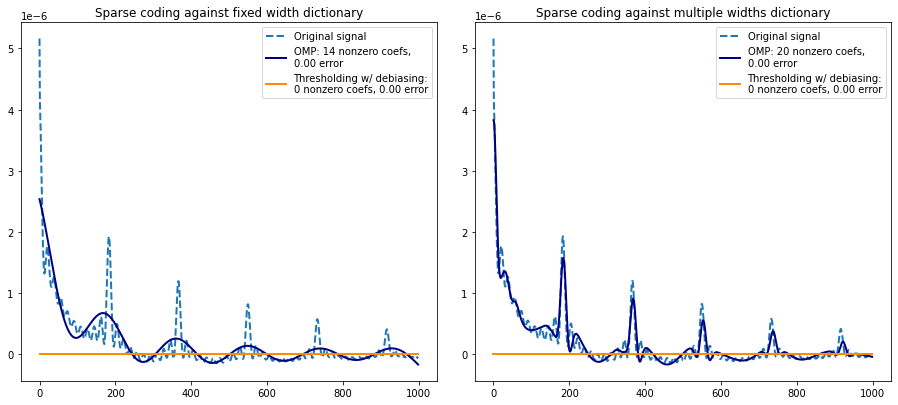

In [11]:



def ricker_function(resolution, center, width):
    """Discrete sub-sampled Ricker (Mexican hat) wavelet"""
    x = np.linspace(0, resolution - 1, resolution)
    x = (
        (2 / (np.sqrt(3 * width) * np.pi**0.25))
        * (1 - (x - center) ** 2 / width**2)
        * np.exp(-((x - center) ** 2) / (2 * width**2))
    )
    return x


def ricker_matrix(width, resolution, n_components):
    """Dictionary of Ricker (Mexican hat) wavelets"""
    centers = np.linspace(0, resolution - 1, n_components)
    D = np.empty((n_components, resolution))
    for i, center in enumerate(centers):
        D[i] = ricker_function(resolution, center, width)
    D /= np.sqrt(np.sum(D**2, axis=1))[:, np.newaxis]
    return D


resolution = 1000
subsampling = 3  # subsampling factor
width = 100
n_components = resolution // subsampling

# Compute a wavelet dictionary
D_fixed = ricker_matrix(width=width, resolution=resolution, n_components=n_components)
D_multi = np.r_[
    tuple(
        ricker_matrix(width=w, resolution=resolution, n_components=n_components // 5)
        for w in (10, 50, 100, 500, 1000)
    )
]

# Generate a signal
y = np.linspace(0, resolution - 1, resolution)
first_quarter = y < resolution / 3
y[first_quarter] = 3.0
y[np.logical_not(first_quarter)] = -1.0

y = learn_s

# List the different sparse coding methods in the following format:
# (title, transform_algorithm, transform_alpha,
#  transform_n_nozero_coefs, color)
estimators = [
    ("OMP", "omp", None, 20, "navy"),
    #("Lasso", "lasso_lars", 2, None, "turquoise"),
]
lw = 2

plt.figure(figsize=(13, 6))
for subplot, (D, title) in enumerate(
    zip((D_fixed, D_multi), ("fixed width", "multiple widths"))
):
    plt.subplot(1, 2, subplot + 1)
    plt.title("Sparse coding against %s dictionary" % title)
    plt.plot(y, lw=lw, linestyle="--", label="Original signal")
    # Do a wavelet approximation
    for title, algo, alpha, n_nonzero, color in estimators:
        coder = SparseCoder(
            dictionary=D,
            transform_n_nonzero_coefs=n_nonzero,
            transform_alpha=alpha,
            transform_algorithm=algo,
        )
        x = coder.transform(y.reshape(1, -1))
        density = len(np.flatnonzero(x))
        x = np.ravel(np.dot(x, D))
        squared_error = np.sum((y - x) ** 2)
        plt.plot(
            x,
            color=color,
            lw=lw,
            label="%s: %s nonzero coefs,\n%.2f error" % (title, density, squared_error),
        )

    # Soft thresholding debiasing
    coder = SparseCoder(
        dictionary=D, transform_algorithm="threshold", transform_alpha=20
    )
    x = coder.transform(y.reshape(1, -1))
    _, idx = np.where(x != 0)
    x[0, idx], _, _, _ = np.linalg.lstsq(D[idx, :].T, y, rcond=None)
    x = np.ravel(np.dot(x, D))
    squared_error = np.sum((y - x) ** 2)
    plt.plot(
        x,
        color="darkorange",
        lw=lw,
        label="Thresholding w/ debiasing:\n%d nonzero coefs, %.2f error"
        % (len(idx), squared_error),
    )
    plt.axis("tight")
    plt.legend(shadow=False, loc="best")
plt.subplots_adjust(0.04, 0.07, 0.97, 0.90, 0.09, 0.2)
plt.show()